# Project

In this project, we will use a cardiovascular disease data set that contains standard health information and information on the presence/absence of cardiovascular disease for over 70,000 patients. Our overarching objective of the project is to predict whether an individual is at a risk for getting cardiovascular disease given his personal data.

In [66]:
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras import layers, models
import pickle

## Obtain Data

In [88]:
url = "https://raw.githubusercontent.com/M-0-N-I-C-A/PIC16B_Project/main/cardio_train.csv"
df = pd.read_csv(url, sep = ';')

In [15]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


## Exploring Our Data Set

We want to have a basic understanding of this data set through the plots below. 

Let's begin by creating a heatmap. 

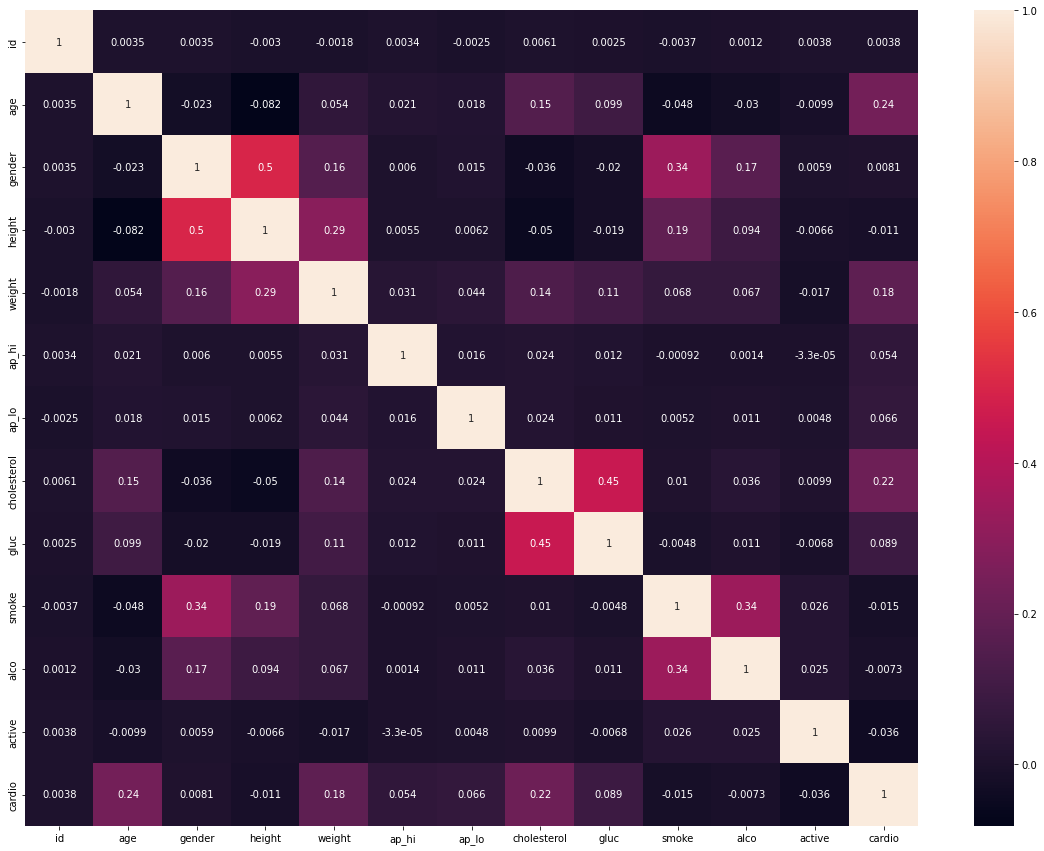

In [4]:
# check correlations
plt.figure(figsize = (20, 15))
fgrid = sns.heatmap(df.corr(), annot = True)

This heatmap shows correlations between different variables in the data set. 
We see that no features directly correlate with the cardio column and generally, there do not exist significant correlations between other variables. However, correlations exist between the following few variables:

- Height and gender columns are correlated with a score of 0.5.
- Gluc and cholesterol columns are correlated with a score of 0.45.
- Smoke and gender columns are correlated with a score of 0.34.

Now we'll write a function to create a box-and-whisker plot.

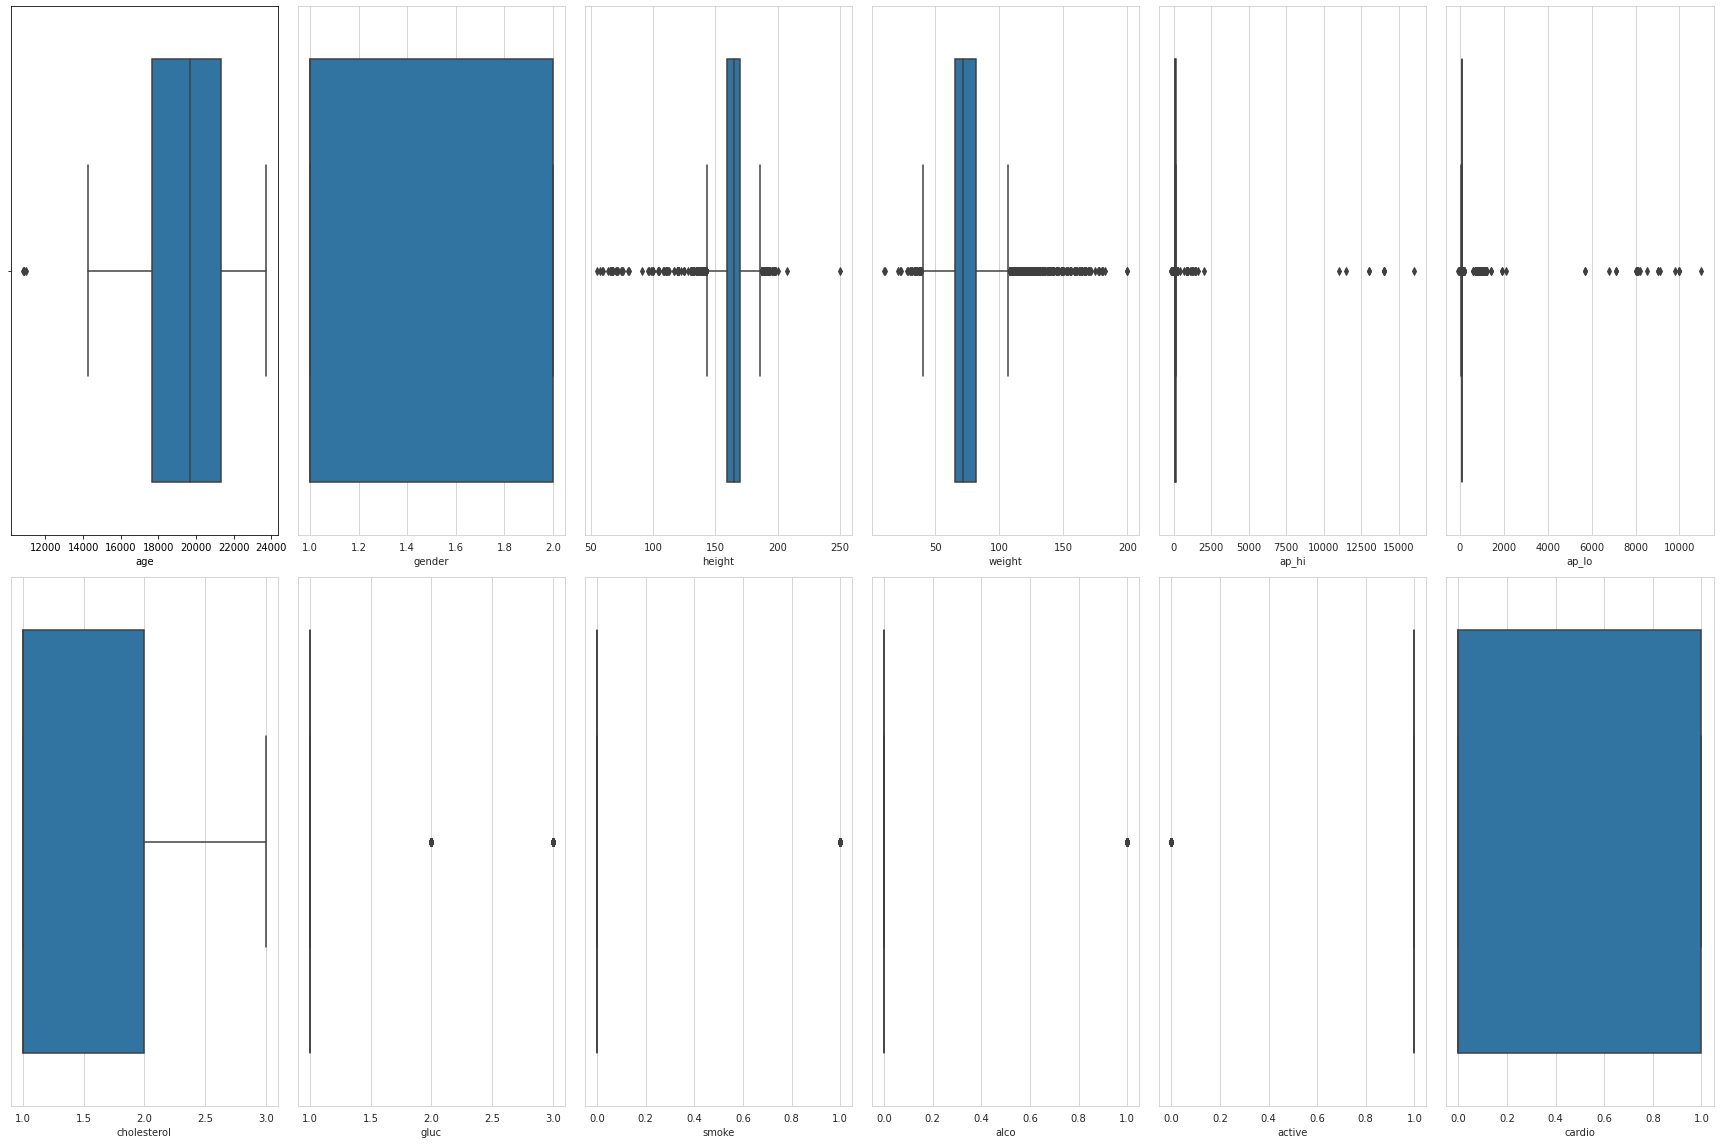

In [5]:
# check outliers
def check_outliers(df):
    """
    Check where the outliers in a dataframe are located. 

    df: a preprocessed dataframe

    No return value
    """
    l = df.columns.values
    number_of_columns = (len(l) - 1) / 2
    number_of_rows = 2
    
    # create a figure
    plt.figure(figsize = (4 * number_of_columns, 8 * number_of_rows))

    # loop over the columns in the data set
    for i in range(1, len(l)):
        # add a subplot in a grid with 2 rows and 6 columns in position i
        ax = plt.subplot(number_of_rows, number_of_columns, i)

        sns.set_style('whitegrid')
        sns.boxplot(x = df[l[i]])

        # stretch the plots so that they don't look "squished"
        plt.tight_layout()


check_outliers(df) # demonstration

As we can see, there are outliers in the data set in the ap_hi and ap_lo columns. Removal of these outliers can potentially improve the accuracy of our model.

Next, we want to write a function to create a kernel density estimate (KDE) plot.

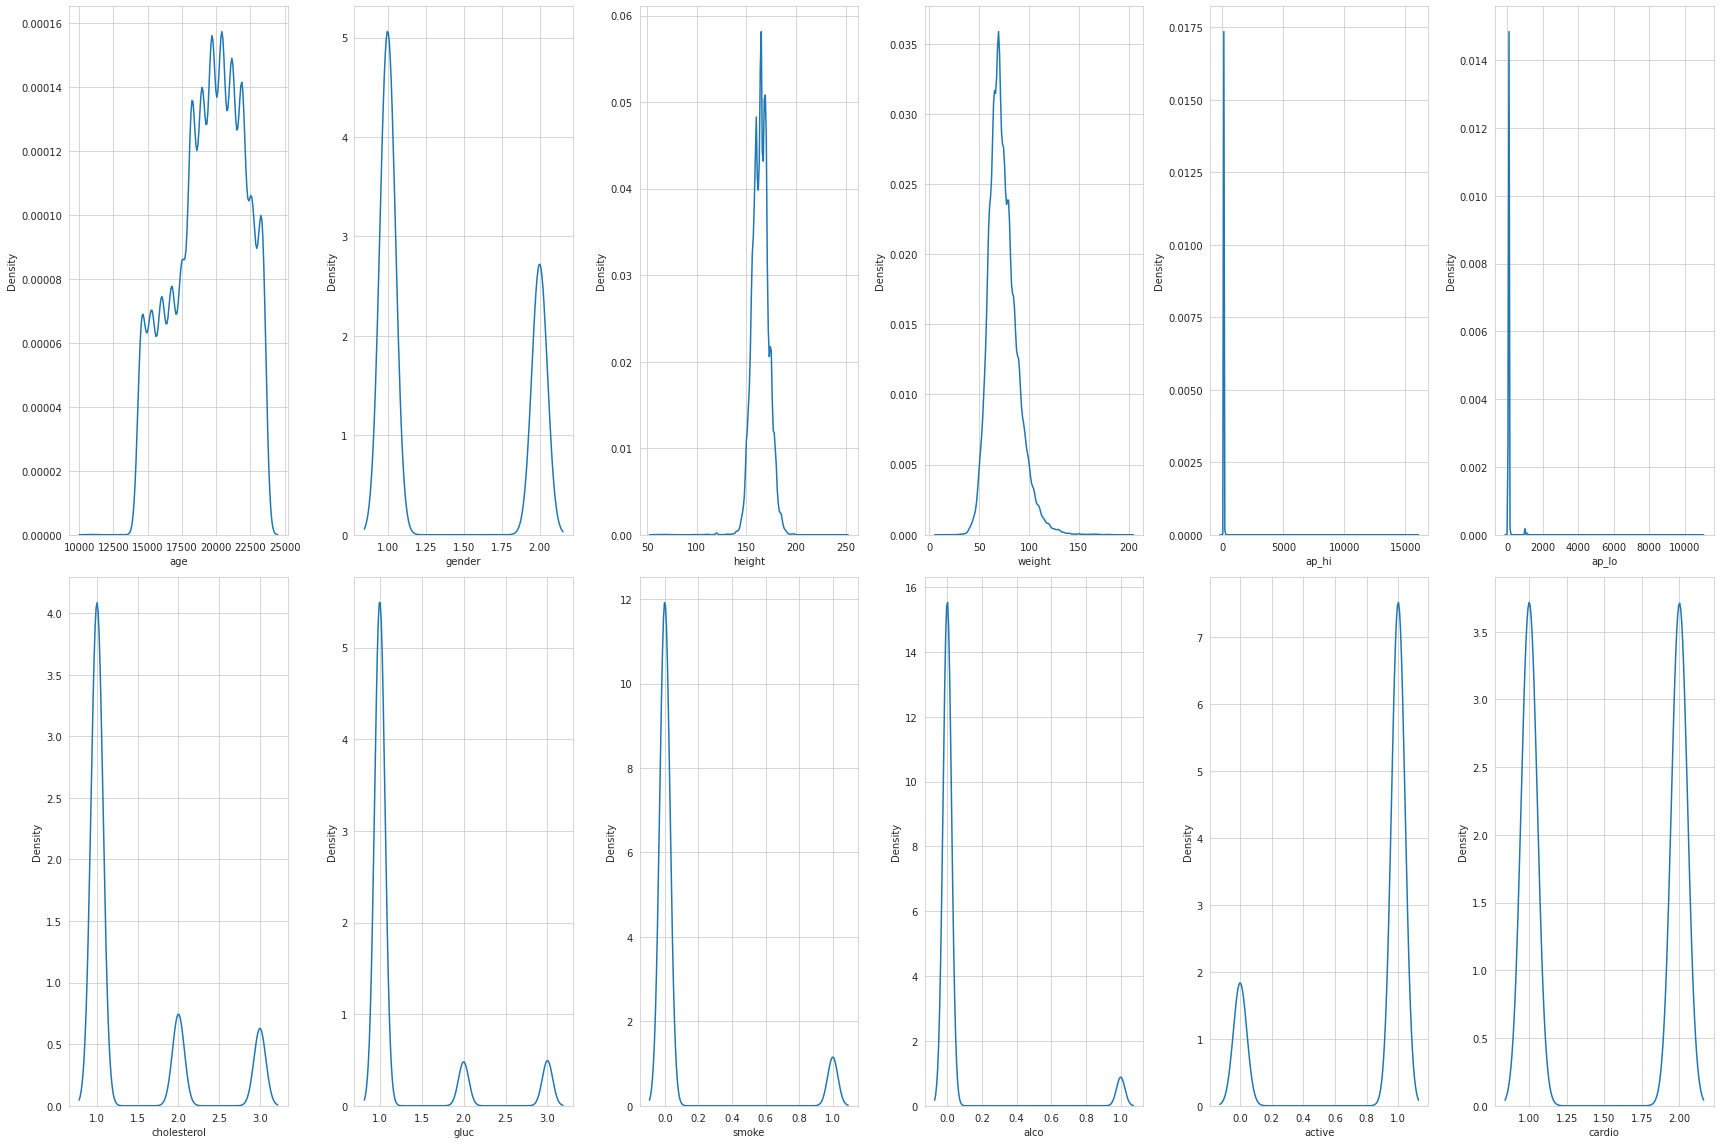

In [7]:
# check distribution
def check_dist(df):
    l = df.columns.values
    number_of_columns = (len(l) - 1) / 2
    number_of_rows = 2
    
    # create a figure
    plt.figure(figsize = (4 * number_of_columns, 8 * number_of_rows))

    # loop over the columns in the data set
    for i in range(1, len(l)):
        # add a subplot in a grid with 2 rows and 6 columns in position i
        plt.subplot(number_of_rows, number_of_columns, i)

        sns.set_style('whitegrid')
        sns.kdeplot(x = df[l[i]]) 

        # stretch the plots so that they don't look "squished"
        plt.tight_layout()
        
check_dist(df) # demonstration

As we can see, the height and weight columns are roughly normally distributed while there are some variations in the age column. Moreover, the histograms corroborate the presence of outliers in the ap_hi and ap_lo columns. Also, there exist categorical variables in the data set: the gender, cholesterol, gluc, smoke, alco, and active columns.

## Clear and Transform Our Data

We'll remove outliers in the ap_hi and ap_lo columns based on the above box-and-whisker plot and plot the data again.

In [89]:
# remove outliers in the ap_hi and ap_lo columns
df = df[df['ap_hi'] < 250]  
df = df[df['ap_lo'] < 250]

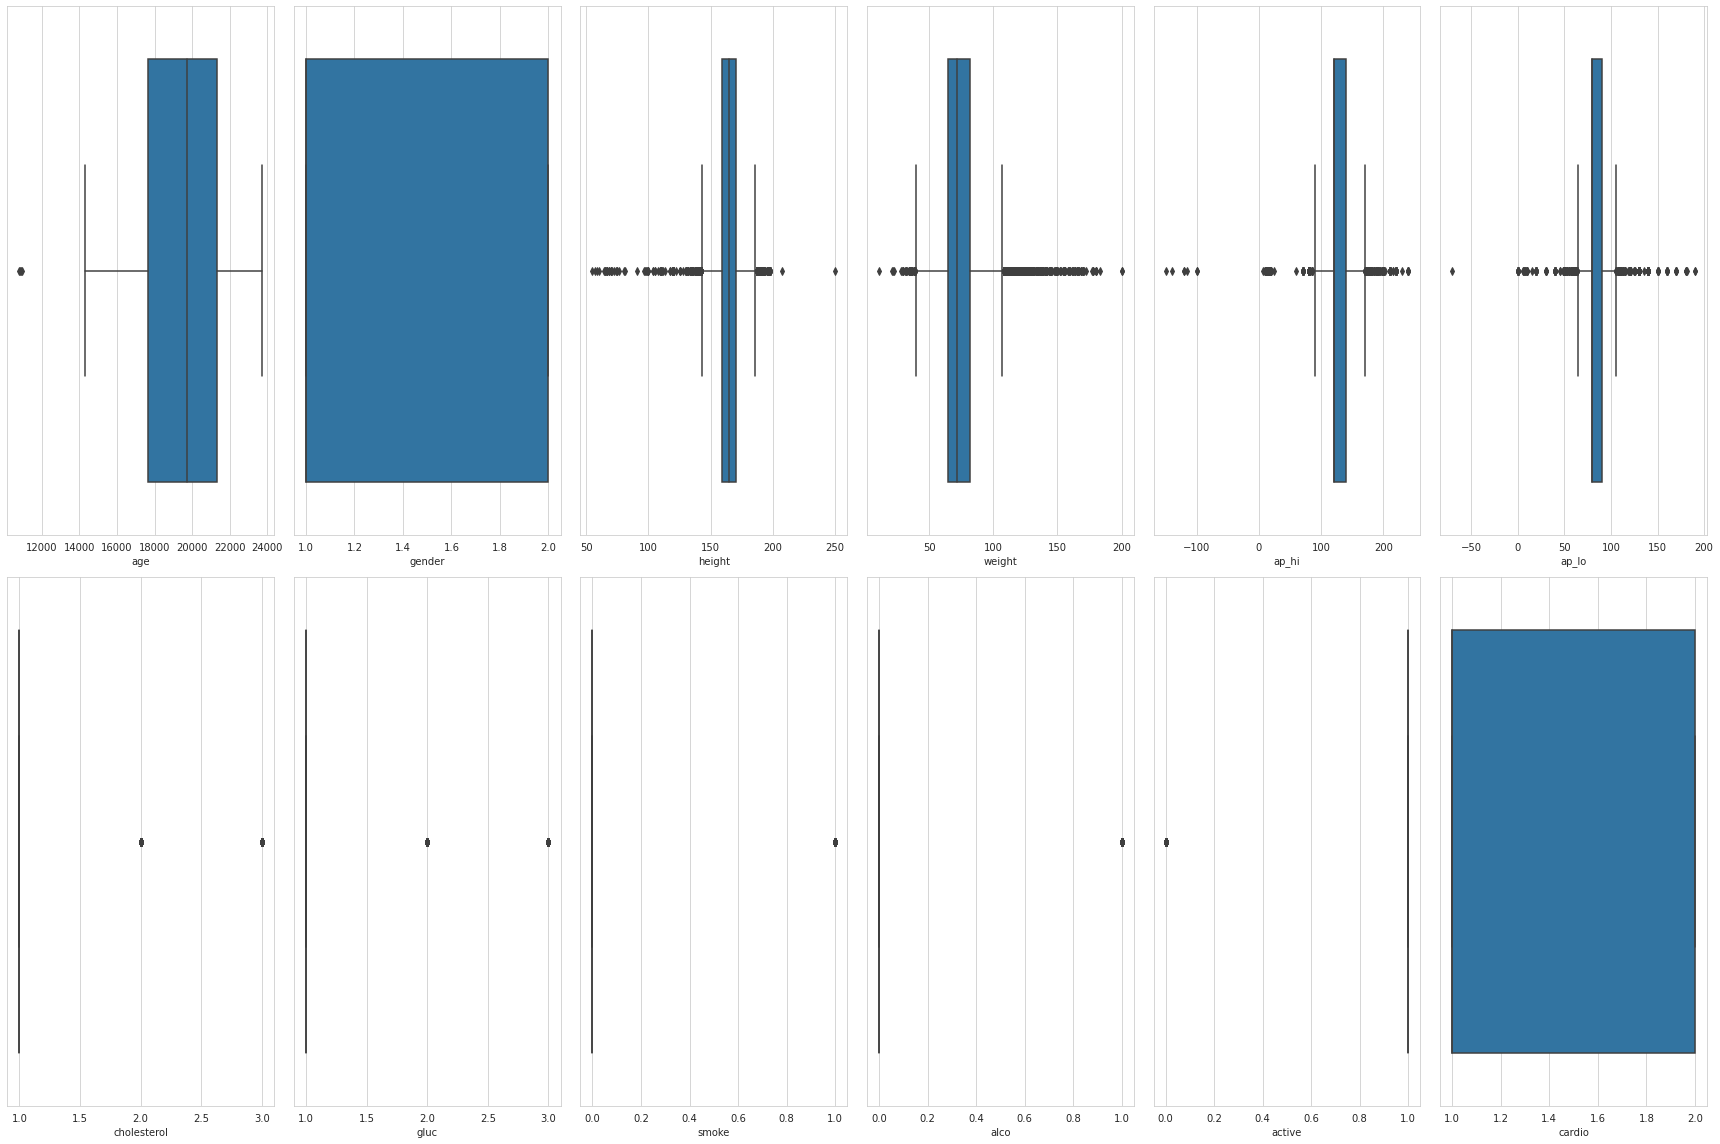

In [9]:
check_outliers(df) # demonstration

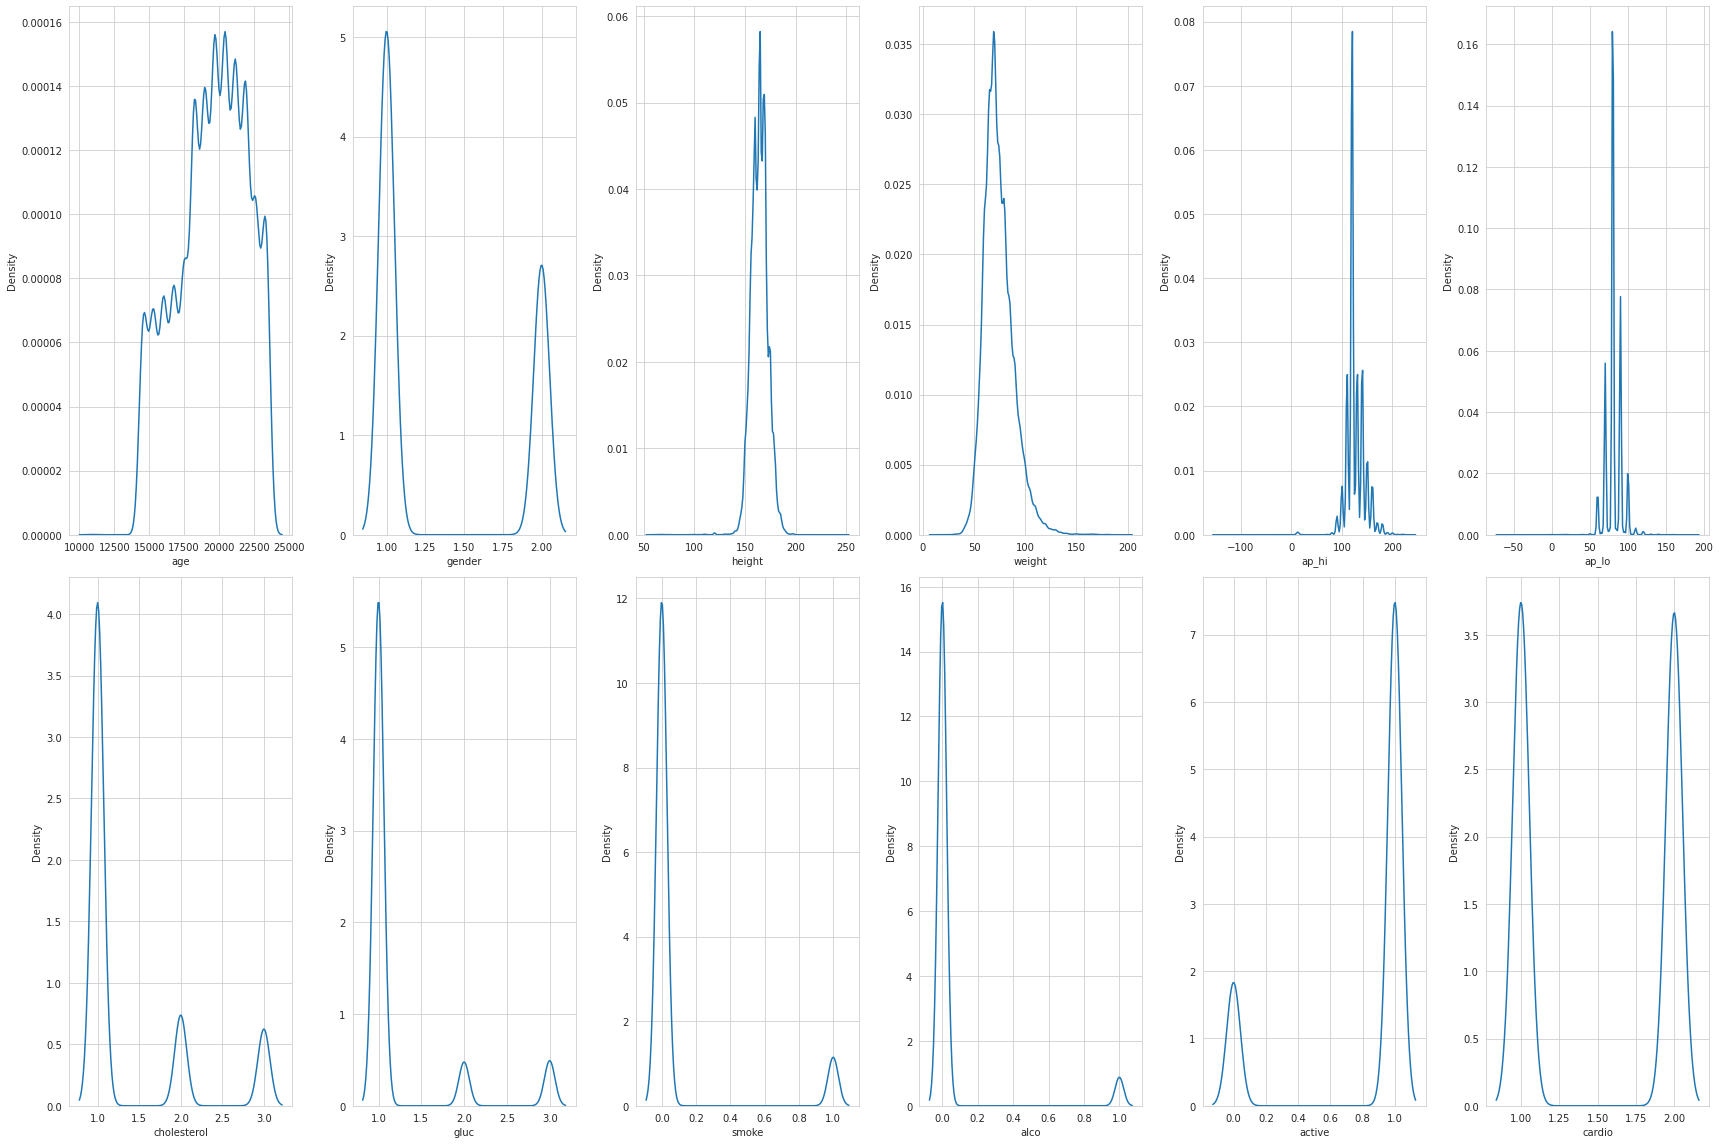

In [10]:
check_dist(df)

As we can see, the ap_hi and ap_lo columns are much more regularly distributed after the removal of outliers, which allows the current data set to provide more meaningful input for our model.

In [90]:
# convert the gender column
df["gender"] = df["gender"] - 1
# rescale the age column
df["age"] = df["age"] // 365
# drop the id column
df = df.drop(["id"], axis = 1)

In [58]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50,1,168,62.0,110,80,1,1,0,0,1,0
1,55,0,156,85.0,140,90,3,1,0,0,1,1
2,51,0,165,64.0,130,70,3,1,0,0,0,1
3,48,1,169,82.0,150,100,1,1,0,0,1,1
4,47,0,156,56.0,100,60,1,1,0,0,0,0


## Check Label Frequencies

Let’s compute the number of rows in the data set with the cardio column equal to 0 (corresponding to the absence of cardiovascular disease) and the number of rows in the data set with the cardio column equal to 1 (corresponding to the presence of the disease).

In [60]:
presence_count = sum(df["cardio"] == 1)
absence_count = sum(df["cardio"] == 0)

# show the numbers
presence_count, absence_count

(34150, 34857)

The *baseline* machine learning model is the model that always guesses the most frequent label. In our case, there is an about equal number of rows in the data set with the cardio column equal to 0 and the cardio column equal to 1. So, the accuracy of the baseline model would be close to 50%.

We’ll treat this as the benchmark for improvement. Our models should do much better than this baseline model in order to be considered good data science achievements!

## Model Based on Heatmap

Let’s create a `tf.keras.models.Sequential` model using `Dense` layers.

We'll first separate the cleaned data set into predictor data consisting of the five columns with the highest correlation scores based on the above heatmap and target data, which is the cardio column. Then we split the data set into training (70%) and test(30%) data. 

In [61]:
# predictor data
X = df[["age", "cholesterol", "weight", "gluc", "ap_lo"]]
# target data
y = df["cardio"]

# hold out 30% of the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [62]:
# create a model
model1 = models.Sequential([
    layers.Dense(500, activation='relu',input_shape=(5,)),
    layers.Dense(500, activation='relu'),
    layers.Dense(2)
])

Now we can use the `model.summary()` to inspect our model.

In [63]:
# show the summary
model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 500)               3000      
                                                                 
 dense_10 (Dense)            (None, 500)               250500    
                                                                 
 dense_11 (Dense)            (None, 2)                 1002      
                                                                 
Total params: 254,502
Trainable params: 254,502
Non-trainable params: 0
_________________________________________________________________


Let’s train our model for 20 epochs and see how it does.

In [64]:
# compile the model
model1.compile(optimizer = "adam",
               loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics = ["accuracy"])

In [65]:
# fit our model
history = model1.fit(X_train, y_train, epochs = 20, verbose=1)

Epoch 1/20
1510/1510 [==============================] - 8s 5ms/step - loss: 0.7650 - accuracy: 0.5319
Epoch 2/20
1510/1510 [==============================] - 8s 5ms/step - loss: 0.6687 - accuracy: 0.5878
Epoch 3/20
1510/1510 [==============================] - 8s 5ms/step - loss: 0.6492 - accuracy: 0.6232
Epoch 4/20
1510/1510 [==============================] - 8s 5ms/step - loss: 0.6277 - accuracy: 0.6519
Epoch 5/20
1510/1510 [==============================] - 8s 5ms/step - loss: 0.6127 - accuracy: 0.6695
Epoch 6/20
1510/1510 [==============================] - 8s 5ms/step - loss: 0.6059 - accuracy: 0.6796
Epoch 7/20
1510/1510 [==============================] - 8s 5ms/step - loss: 0.6034 - accuracy: 0.6805
Epoch 8/20
1510/1510 [==============================] - 8s 5ms/step - loss: 0.6011 - accuracy: 0.6831
Epoch 9/20
1510/1510 [==============================] - 8s 5ms/step - loss: 0.6000 - accuracy: 0.6835
Epoch 10/20
1510/1510 [==============================] - 8s 5ms/step - loss: 0.597

Next, we’ll visualize the training history.

[Text(0, 0.5, 'training accuracy'), Text(0.5, 0, 'epoch')]

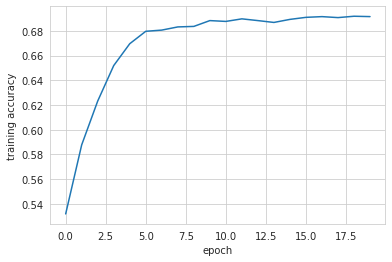

In [66]:
# plot the history of the accuracy on the training set
plt.plot(history.history["accuracy"])
# label the axes
plt.gca().set(xlabel = "epoch", ylabel = "training accuracy")

As we can see, our model can ahieve 69% training accuracy at the end. This is better than the baseline model.

# Model with All Columns

Let’s again create a `tf.keras.models.Sequential` model using `Dense` layers.

The predictor data now contains all of the  columns in the data set.

In [67]:
# predictor data
X = df.drop(["cardio"], axis = 1)
# target data
y = df[["cardio"]]

# hold out 30% of the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [68]:
# create a model
model2 = models.Sequential([
    layers.Dense(500, activation='relu',input_shape=(11,)),
    layers.Dense(500, activation='relu'),
    layers.Dense(2)
])

Now we can use the `model.summary()` to inspect our model.

In [69]:
# show the summary
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 500)               6000      
                                                                 
 dense_13 (Dense)            (None, 500)               250500    
                                                                 
 dense_14 (Dense)            (None, 2)                 1002      
                                                                 
Total params: 257,502
Trainable params: 257,502
Non-trainable params: 0
_________________________________________________________________


Let’s train our model for 20 epochs and see how it does.

In [70]:
model2.compile(optimizer = "adam",
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ["accuracy"])

In [71]:
history = model2.fit(X_train, y_train, epochs = 20, verbose=1)

Epoch 1/20
1510/1510 [==============================] - 8s 5ms/step - loss: 0.8438 - accuracy: 0.6593
Epoch 2/20
1510/1510 [==============================] - 8s 6ms/step - loss: 0.5902 - accuracy: 0.6960
Epoch 3/20
1510/1510 [==============================] - 8s 5ms/step - loss: 0.5777 - accuracy: 0.7051
Epoch 4/20
1510/1510 [==============================] - 8s 5ms/step - loss: 0.5731 - accuracy: 0.7095
Epoch 5/20
1510/1510 [==============================] - 8s 5ms/step - loss: 0.5730 - accuracy: 0.7115
Epoch 6/20
1510/1510 [==============================] - 8s 5ms/step - loss: 0.5719 - accuracy: 0.7132
Epoch 7/20
1510/1510 [==============================] - 8s 5ms/step - loss: 0.5692 - accuracy: 0.7158
Epoch 8/20
1510/1510 [==============================] - 8s 5ms/step - loss: 0.5697 - accuracy: 0.7138
Epoch 9/20
1510/1510 [==============================] - 8s 5ms/step - loss: 0.5684 - accuracy: 0.7142
Epoch 10/20
1510/1510 [==============================] - 8s 5ms/step - loss: 0.566

[Text(0, 0.5, 'training accuracy'), Text(0.5, 0, 'epoch')]

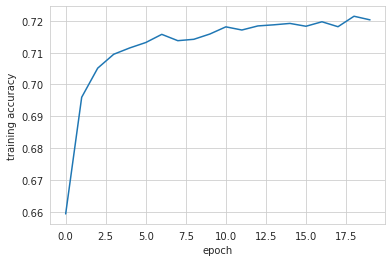

In [72]:
# plot the history of the accuracy on the training set
plt.plot(history.history["accuracy"], label = "training")
# label the axes
plt.gca().set(xlabel = "epoch", ylabel = "training accuracy")

As we can see, our model can ahieve 72% training accuracy at the end. This is better than the baseline model.

## Score on Test Data

`model2` is our most performant model. Let’s evaluate the accuracy of `model2` on the unseen test data set.

In [73]:
model2.evaluate(X_test, y_test, verbose = 2)

647/647 - 1s - loss: 0.5635 - accuracy: 0.7162 - 1s/epoch - 2ms/step


[0.5635198950767517, 0.716224730014801]

As we can see, the accuracy on testing data is approximaley 72%.

## Logistic Regression Model

As we attempted to incorporate the tensorflow model into our webpage through pickling, it showed up some unexpected error. Therefore, we tried to switch the tensorflow model to LosgisticRegression so that it's easier to pickle and apply it on our app.py file

Again, We first split the cleaned data set into predictor data consisting of five variables and target data (cardio). Then we split the data set into training(70%) and testing sets(30%). We then deploy the LogisticRegression model, fit the model by training data. The training history is shown in the plot below. We can see that this all-features combination of using LogisticRegression model yielded a prediction accuracy at around 73% on testing data.

In [91]:
X = df.drop(["cardio"], axis = 1)

y = df["cardio"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [92]:
model3 = LogisticRegression(random_state = 0, solver = "liblinear")

In [93]:
model3.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [94]:
model3.score(X_test, y_test)

0.7240979568178525

## Pickling

We are going to pickle the model so that we can use it our app.py file. We pickle the model by calling pickle.dump with an open file connection.

In [95]:
import pickle
filename = 'cardio-model/model.pkl'
pickle.dump(model3, open(filename, 'wb'))